# Statistical Models

### Will this Animal be Adopted?

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sheltertools.utils import *
import random
random.seed(159)

In [38]:
shelter_data = pd.read_csv('./data/Animal_Shelter_Data.csv')
shelter_data.dropna(subset=['Size'], inplace=True)

In [39]:
shelter_data.rename(columns={'Intake Subtype': 'Intake_Subtype',
                            'Intake Type': 'Intake_Type',
                            'Intake Condition': 'Intake_Condition'}, inplace=True)

In [40]:
# Create a new column named Adopted, and assign a value of 0 or 1 
# to indicate whether each animal has been adopted or not.
shelter_data['Adopted'] = (shelter_data['Outcome Type'] == 'ADOPTION').astype(int)
shelter_data['Intake Year'] = shelter_data['Intake Date'].apply(lambda x: x[-4:])

#Split the data into test and train
shelter_train, shelter_test = train_test_split(shelter_data, test_size=0.3, random_state=159)
shelter_train.shape, shelter_test.shape

((17481, 26), (7492, 26))

In [41]:
import statsmodels.formula.api as smf
logreg = smf.logit(formula = 'Adopted ~ Type + Sex + Size + Intake_Type + Intake_Condition',
                       data = shelter_train).fit()
print(logreg.summary())

         Current function value: 0.357273
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Adopted   No. Observations:                17481
Model:                          Logit   Df Residuals:                    17457
Method:                           MLE   Df Model:                           23
Date:                Tue, 09 May 2023   Pseudo R-squ.:                  0.4094
Time:                        23:23:19   Log-Likelihood:                -6245.5
converged:                      False   LL-Null:                       -10575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.2155      0.201     -1.072      0.284

/srv/conda/envs/notebook/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# Predicting the probability of adopted
y_prob = logreg.predict(shelter_test)

# Predicting the label: 0 or 1?
y_pred = pd.Series([1 if x > 1/2 else 0 for x in y_prob], index=y_prob.index)

from sklearn.metrics import confusion_matrix
y_test = shelter_test['Adopted']
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[4820  460]
 [ 809 1403]]


In [43]:
TN, FP, FN, TP = cm.ravel()

# What is the Accuracy?
acc= (TN + TP) / sum(cm.ravel())
print('Accuracy is: %.4f' %acc)


# What is the True Positive Rate ?
TPR_logit = TP/(TP+FN)
print('TPR is: %.4f' % TPR_logit)

# What is the False Positive rate ?
FPR_logit = FP/(FP+TN)
print('FPR is: %.4f' % FPR_logit)

Accuracy is: 0.8306
TPR is: 0.6343
FPR is: 0.0871


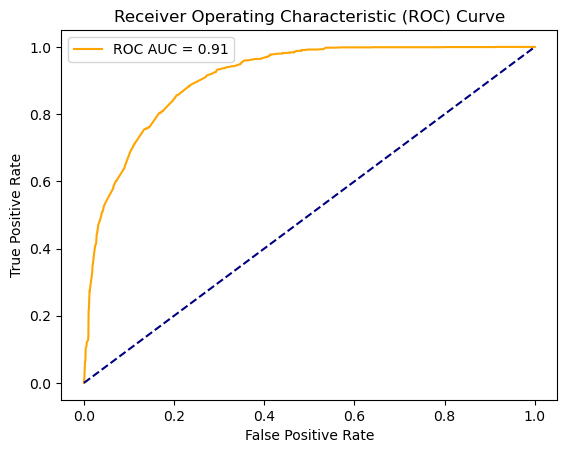

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, color='orange', label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

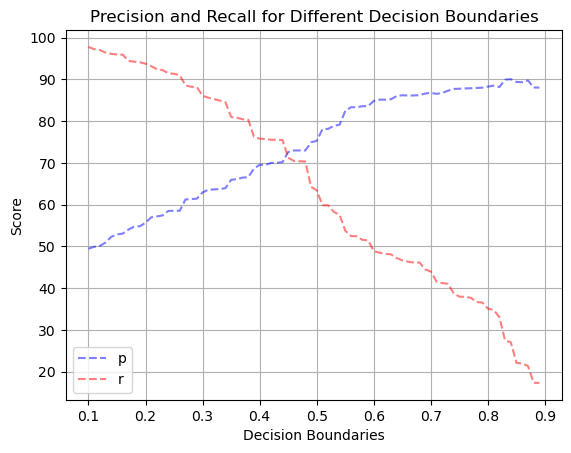

In [45]:
from sklearn.metrics import precision_score, recall_score

boundary_precisions = []
boundary_recalls = []
                       
for b in np.arange (0.1, 0.9, 0.01) :
    boundary_predictions = (y_prob >= b).astype(int)
    boundary_precisions.append(precision_score(y_test, boundary_predictions) * 100)
    boundary_recalls.append(recall_score(y_test, boundary_predictions) * 100)
    
plt.plot(np.arange(0.1, 0.9, 0.01), boundary_precisions, color='blue', linestyle='--', alpha=0.5, label='p')

plt.plot(np.arange(0.1, 0.9, 0.01), boundary_recalls, color='red', linestyle='--', alpha=0.5, label='r')


plt.xlabel('Decision Boundaries')
plt.ylabel('Score')
plt.title( 'Precision and Recall for Different Decision Boundaries')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Our model predicting whether or not an animal will be adopted performed adequately. It achieved an accuracy of 83%, true positive rate of 63%, and a 9% false positive rate when using a standard 0.5 decision boundary. The ROC-AUC score was 0.91. When plotting the precision and recall rates using different decision boundaries, both lines intersected around 72%

### How Many Days Before Adoption?

In [46]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']

### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake_Type', 'Intake_Subtype', 'Intake_Condition', 'Intake Jurisdiction', 'Location',
                      'Intake Year']]
adopted = adopted.reset_index(drop=True)

### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')

In [47]:
adopted_all['Intake Year']

10       2022
13       2022
18       2020
19       2022
20       2023
         ... 
24990    2014
24991    2016
24997    2016
24998    2017
25003    2019
Name: Intake Year, Length: 7337, dtype: object

In [48]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']

### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake_Type', 'Intake_Subtype', 'Intake_Condition', 'Intake Jurisdiction', 'Location',
                      'Intake Year']]
adopted = adopted.reset_index(drop=True)

### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')

In [49]:
adopted_all.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake_Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count', 'Adopted', 'Intake Year'],
      dtype='object')

In [50]:
adopted['log_days'] = np.log1p(adopted['Days in Shelter'])

In [51]:
adopted_filtered = adopted[adopted['Days in Shelter']< 200]

In [52]:
!pip install catboost -q

In [53]:
### test train split
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(adopted_filtered.drop(['Days in Shelter', 'log_days'], axis=1), 
                                                    adopted_filtered['log_days'], test_size=0.2, random_state=42)

In [54]:
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], loss_function='MAE', verbose=500,
                         depth=9, iterations=1500, learning_rate=0.05)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0:	learn: 0.6458547	total: 24.3ms	remaining: 36.4s
500:	learn: 0.3103670	total: 12.1s	remaining: 24s
1000:	learn: 0.2503310	total: 24.7s	remaining: 12.3s
1499:	learn: 0.2160745	total: 38.3s	remaining: 0us


In [55]:
import pickle

# Save the model
with open('model_results/' + 'CatBoostRegressor.pickle', 'wb') as f:
    pickle.dump(model, f)

# Save the predictions
with open('model_results/' + 'CatPredictions.pickle', 'wb') as f:
    pickle.dump(predictions, f)


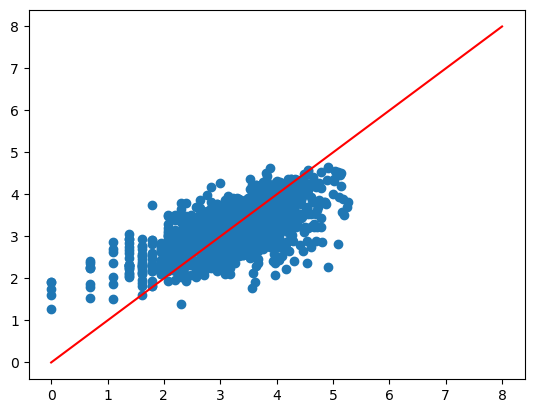

In [56]:
x = np.linspace(0, 8, 100)
y = x

plt.plot(x, y, color='red');
plt.scatter(x=y_test, y=predictions);
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

unlog_pred = np.expm1(predictions)
unlog_actual = np.expm1(y_test)

rmse = mean_squared_error(unlog_actual, unlog_pred, squared=False)
r2 = r2_score(y_test, predictions)

print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 22.60
R2: 0.48


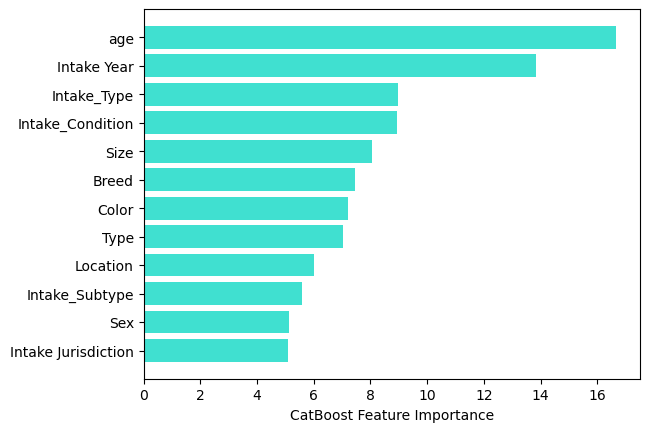

In [58]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance");

Our model predicting the number of days before adoption did not perform very well. We transformed the target values as it followed an exponential distribution, but the model still did not perform very well. The RMSE was 22.6 days, and the R squared value was quite low, at 0.36.

But the feature importances for the CatBoost were help. It tells us that Age and Intake yere were the top 2 most important features when performing the regression.